# NEAR Act Report on Felony Crime for 2016: data cleaning

In this notebook, we transform the raw data that we got from the Metropolitan Police Department (MPD), the Superior Court, and the Department of Behavioral Health (DBH) into clean data for our analysis. This is notebook 1 of 2.

In [1]:
import binascii
import math
import os
import secrets
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Set working directories

RAWDATA_DIR = os.path.join('..', 'data', 'rawdata')
PUBLIC_OUTPUT_DATA = os.path.join('..', 'data', 'public_output_data')
NOT_PUBLIC_OUTPUT_DATA = os.path.join('..', 'data', 'not_public_output_data')

## Read in raw data

In [3]:
### Metropolitan Police Department (MPD) ###

# MPD's felony arrest records (each row is a felony charge against a person in an arrest)
arrest_charges = pd.read_csv(os.path.join(RAWDATA_DIR, 'arrests_11-15-17.csv'))

# MPD records of felony crime reports (each row is a victim or suspect involved in an incident, which are identified by CCN)
crimes = pd.read_csv(os.path.join(RAWDATA_DIR, 'crimes_11-15-17.csv'))


### Superior Court ###

# Superior Court case records at the charge level (each row is a charge against a person in a specific case)
case_charges = pd.read_csv(os.path.join(RAWDATA_DIR, 'case_charges.csv'))


### Department of Behavioral Health (DBH) ###

# Outpatient mental health service records from providers
mh_raw = pd.read_csv(os.path.join(RAWDATA_DIR, 'dbh_mh_raw.csv'))

# Saint Elizabeth's hospital intake/discharge records
seh_raw = pd.read_csv(os.path.join(RAWDATA_DIR, 'dbh_seh_raw.csv'))

# Substance use disorder treatment records
sud_raw = pd.read_csv(os.path.join(RAWDATA_DIR, 'dbh_sud_raw.csv'))

# CIO reported incidents from DBH
cio = pd.read_csv(os.path.join(RAWDATA_DIR, 'cio_incidents.csv'))


### DM PSJ Charge Categories ###

# Dictionary of arrest categories
dmpsj_charge_categories = pd.read_csv(os.path.join(RAWDATA_DIR, 'dmpsj_charge_categories.csv'))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (4,18,21,23,24,26,27,28,29,34,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Name dataframes (used in for loops)

arrest_charges.name = 'MPD felony arrest charge records'
case_charges.name = 'Superior Court case records'
crimes.name = 'MPD felony crime incident records'
cio.name = 'MPD crisis intervention incident records'
mh_raw.name = 'DBH mental health service records'
seh_raw.name = 'DBH Saint Elizabeths service records'
sud_raw.name = 'DBH substance use disorder treatment records'

In [5]:
COLUMN_RENAMES = {
    
    # Columns from the Court:
    'CASE_ID': 'case_id',
    'CASE TYPE': 'case_type',
    'CASE_NO': 'case_no',
    'FILE DATE': 'file_date',
    'PDID': 'pdid',
    'LAST NAME': 'last_name',
    'FIRST NAME': 'first_name',
    'DOB': 'dob',
    'GENDER': 'sex',
    'RACE': 'race',
    'CHRG NBR': 'charge_number',
    'OFFENSE DATE': 'offense_date',
    'ARREST CHRG CD': 'court_arrest_code',
    'ARREST CHRG DSCR': 'arrest_charge_description',
    'PROS ATTEMPT CD': 'prosecution_attempt_code',
    'PROS ATTEMPT DSCR': 'prosecution_attempt_description',
    'PROS ATTEMPT SEQ': 'prosecution_attempt_sequence',
    'PROS CHRG CD': 'prosecution_charge_code',
    'PROS CHRG DSCR': 'prosecution_charge_description',
    'PROS ENHANCE CD': 'prosecution_enhance_code',
    'PROS ENHANCE DSCR': 'prosecution_enhance_description',
    'PROS ENHANCE SEQ': 'prosecution_enhance_sequence',
    'INDICT ATTEMPT CD': 'indict_attempt_code',
    'INDICT ATTEMPT DSCR': 'indict_attempt_description',
    'INDICT ATTEMPT SEQ': 'indict_attempt_sequence',
    'INDICT CHRG CD': 'indict_charge_code',
    'INDICT CHRG DSCR': 'indict_charge_description',
    'INDICT ENHANCE CD': 'indict_enhance_code',
    'INDICT ENHANCE SEQ': 'indict_enhance_sequence',
    'INDICT ENHANCE DSCR': 'indict_enhance_description',
    'COURT ATTEMPT CD': 'court_attempt_code',
    'COURT ATTEMPT DSCR': 'court_attempt_description',
    'COURT ATTEMPT SEQ': 'court_attempt_sequence',
    'COURT CHRG CD': 'court_charge_code',
    'COURT CHRG DSCR': 'court_charge_description',
    'COURT ENHANCE CD': 'court_enhance_code',
    'COURT ENHANCE DSCR': 'court_enhance_description',
    'COURT ENHANCE SEQ': 'court_enhance_sequence',
    'CHRG DISP CD': 'charge_disposition_code',
    'CHRG DISP DATE': 'charge_disposition_date',
    'CHRG DISPOSITION': 'charge_disposition',
    
    # Columns from MPD:
    'CCN': 'ccn',
    'Arrest Location Latitude': 'latitude',
    'Arrest Location Longitude': 'longitude',  
    '#ArrestsPerPDID(Past10YRs)': 'arrest_count',
    'Age': 'age',
    'Arrest Charge Category Description': 'mpd_charge_category',
    'Arrest charge disposition': 'mpd_charge_disposition',
    'Arrest Date': 'mpd_arrest_date',
    'Arrest Disposition Date': 'mpd_disposition_date',
    'Arrest location District': 'arrest_district',
    'Arrest location PSA': 'arrest_psa',
    'Arrest Number': 'mpd_arrest_number',
    'Charge Description': 'mpd_charge_description',
    'Defendant DOB': 'dob',
    'Defendant Ethnicity': 'ethnicity',
    'Defendant First Name': 'first_name',
    'Defendant Home address PSA': 'home_psa',
    'Defendant Last Name': 'last_name',
    'Defendant PDID Number': 'pdid',
    'Defendant Race': 'race',
    'Defendant Sex': 'sex',
    'Home Address': 'home_address',
    'Home City': 'home_city',
    'Home State': 'home_state',
    'Home Zipcode': 'home_zip',
    'Person Type': 'person_type',
    'Statute code': 'charge_code',
    'Top Charge': 'top_charge',
    
    # Crime data columns (from MPD)
    'CCN': 'ccn',
    'Offense Report Date': 'offense_report_date',
    'Profile Type': 'profile_type',
    'Offense Category Description': 'offense_category',
    'Offense Description': 'offense_description',
    'Statute Code': 'charge_code',
    'Sex': 'sex',
    'Ethnicity': 'ethnicity',
    'Race': 'race',
    'Home address PSA': 'home_psa',
    'Offense Location District': 'offense_location_district',
    'Offense Location PSA': 'offense_location_psa',
    'Offense Location Latitude': 'latitude',
    'Offense Location Longitude': 'longitude',
    
    # From the CIO data (DBH)   
    'FY': 'fy',
    'IncidentDate': 'date',
    'officerdistrict': 'officer_district',
    'typeoftransport': 'transport_type',
    'RaceEthnicity': 'race',
    'OriginOfCall': 'call_origin',
    'cio_officer': 'is_cio_officer',
    'unique_incident_id': 'incident_id',
    'unique_person_id': 'person_id',
    
    # DBH columns
    'Admitted Date': 'admit_date',  # (nb: these are two separate columns from two different source datasets)
    'Admission Date': 'admit_date', # (nb: these are two separate columns from two different source datasets)
    'Age': 'age',
    'Arrest_ID': 'arrest_id',
    'Arrest_count': 'arrest_count',
    'Base': 'base',
    'Category': 'category',
    'Charge_code': 'charge_code',
    'Consumer_ID': 'consumer_id',
    'Discharge Date': 'discharge_date',
    'EPISODE_NUMBER': 'episode_number',
    'Ethnicity': 'ethnicity',
    'Level of Care': 'level_of_care',
    'MH Provider 2': 'mh_provider_2',
    'MH Service Date': 'mh_service_date',
    'MH Service Type ': 'mh_service_type',
    'Max': 'max',
    'Mpd_arrest_code': 'mpd_arrest_code',
    'Mpd_charge_category': 'mpd_charge_category',
    'Mpd_charge_description': 'mpd_charge_description',
    'Race': 'race',
    'Sex': 'sex',
    'Theme': 'theme',
    'month': 'month',
    'year': 'year',
    'ym': 'ym'

}

In [6]:
# Rename columns for all the dataframes using the index above

dataframes = [arrest_charges, crimes, case_charges, cio, mh_raw, seh_raw, sud_raw]
for df in dataframes:
    df.rename(columns=COLUMN_RENAMES, inplace=True)

In [7]:
# Tag DBH datasets with their source

mh_raw['source'] = 'Mental health services'
seh_raw['source'] = 'Saint Elizabeth\'s'
sud_raw['source'] = 'Substance use services'

## Properties of the source data

#### Arrest charges

In [8]:
# Rows x columns
arrest_charges.shape

(18671, 28)

In [9]:
# Source column names after rename
list(arrest_charges)

['mpd_arrest_number',
 'mpd_arrest_date',
 'person_type',
 'top_charge',
 'mpd_charge_category',
 'mpd_charge_description',
 'charge_code',
 'age',
 'arrest_count',
 'race',
 'ethnicity',
 'sex',
 'home_psa',
 'arrest_district',
 'arrest_psa',
 'mpd_charge_disposition',
 'mpd_disposition_date',
 'home_address',
 'home_city',
 'home_state',
 'home_zip',
 'dob',
 'pdid',
 'first_name',
 'last_name',
 'ccn',
 'latitude',
 'longitude']

#### Superior Court case records

In [10]:
# Rows x columns
case_charges.shape

(114862, 41)

In [11]:
# Source data column names after being renamed
list(case_charges)

['case_id',
 'case_type',
 'case_no',
 'file_date',
 'pdid',
 'last_name',
 'first_name',
 'dob',
 'sex',
 'race',
 'charge_number',
 'offense_date',
 'court_arrest_code',
 'arrest_charge_description',
 'prosecution_attempt_sequence',
 'prosecution_attempt_code',
 'prosecution_charge_code',
 'prosecution_enhance_sequence',
 'prosecution_enhance_code',
 'prosecution_attempt_description',
 'prosecution_charge_description',
 'prosecution_enhance_description',
 'indict_attempt_sequence',
 'indict_attempt_code',
 'indict_charge_code',
 'indict_enhance_sequence',
 'indict_enhance_code',
 'indict_attempt_description',
 'indict_charge_description',
 'indict_enhance_description',
 'court_attempt_sequence',
 'court_attempt_code',
 'court_charge_code',
 'court_enhance_sequence',
 'court_enhance_code',
 'court_attempt_description',
 'court_charge_description',
 'court_enhance_description',
 'charge_disposition_date',
 'charge_disposition_code',
 'charge_disposition']

#### Crime incident data

In [12]:
# Rows x columns
crimes.shape

(96380, 16)

In [13]:
# Source data column names after being renamed
list(crimes)

['ccn',
 'person_type',
 'offense_report_date',
 'profile_type',
 'offense_category',
 'offense_description',
 'charge_code',
 'age',
 'race',
 'ethnicity',
 'sex',
 'home_psa',
 'offense_location_district',
 'offense_location_psa',
 'latitude',
 'longitude']

#### Crisis intervention incident data

In [14]:
# Rows x columns 
cio.shape

(2760, 11)

In [15]:
# Source data column names after being renamed
list(cio)

['fy',
 'date',
 'age',
 'officer_district',
 'sex',
 'transport_type',
 'race',
 'call_origin',
 'is_cio_officer',
 'incident_id',
 'person_id']

#### DBH data

In [16]:
mh_raw.shape

(183287, 21)

In [17]:
list(mh_raw)

['consumer_id',
 'arrest_id',
 'mh_service_date',
 'mh_service_type',
 'mh_provider_2',
 'mpd_charge_category',
 'mpd_charge_description',
 'mpd_arrest_code',
 'age',
 'arrest_count',
 'race',
 'ethnicity',
 'sex',
 'charge_code',
 'base',
 'theme',
 'max',
 'year',
 'month',
 'ym',
 'source']

In [18]:
seh_raw.shape

(3419, 22)

In [19]:
list(seh_raw)

['consumer_id',
 'arrest_id',
 'episode_number',
 'admit_date',
 'discharge_date',
 'category',
 'mpd_charge_category',
 'mpd_charge_description',
 'mpd_arrest_code',
 'age',
 'arrest_count',
 'race',
 'ethnicity',
 'sex',
 'charge_code',
 'base',
 'theme',
 'max',
 'year',
 'month',
 'ym',
 'source']

In [20]:
sud_raw.shape

(6216, 20)

In [21]:
list(sud_raw)

['consumer_id',
 'arrest_id',
 'admit_date',
 'level_of_care',
 'mpd_charge_category',
 'mpd_charge_description',
 'mpd_arrest_code',
 'age',
 'arrest_count',
 'race',
 'ethnicity',
 'sex',
 'charge_code',
 'base',
 'theme',
 'max',
 'year',
 'month',
 'ym',
 'source']

## Categorize charges
This section takes the raw charge codes and groups them into custom categories.

In [22]:
# Create a new column containing the charge code from the most recent stage of the court case

case_charges['charge_code'] = case_charges.court_charge_code.combine_first(case_charges.indict_charge_code)\
                                .combine_first(case_charges.prosecution_charge_code)\
                                .combine_first(case_charges.court_arrest_code)


# Create a new column containing the charge description from the most recent stage of the court case

case_charges['charge_description'] = case_charges.court_charge_description.combine_first(case_charges.indict_charge_description)\
                                .combine_first(case_charges.prosecution_charge_description)\
                                .combine_first(case_charges.arrest_charge_description)

In [23]:
print('Records missing charge codes:', case_charges['charge_code'].isnull().sum())
print('Records missing charge descriptions:', case_charges['charge_description'].isnull().sum())

Records missing charge codes: 2
Records missing charge descriptions: 2


In [24]:
# Strip blanks and ensure consistent capitalization of charge codes and case numbers

for column in ['charge_disposition_code', 'case_no', 'court_charge_code', 'charge_code']:
    case_charges[column] = case_charges[column].str.strip().str.upper()

for column in ['court_charge_description', 'charge_description']:
    case_charges[column] = case_charges[column].str.strip()

arrest_charges['charge_code'] = arrest_charges['charge_code'].str.strip().str.upper()
crimes['charge_code'] = crimes.charge_code.str.strip().str.upper()
dmpsj_charge_categories['charge_code'] = dmpsj_charge_categories['charge_code'].str.upper()

#### Join offense categories to court case records

In [25]:
len(case_charges)

114862

In [26]:
# Merge DMPSJ categories on charges
case_charges = pd.merge(case_charges, 
                        dmpsj_charge_categories[['charge_code', 'dmpsj_category']], 
                        on='charge_code', how='left')

In [27]:
len(case_charges)

114862

In [28]:
# Number of rows that did not match between the court case and categorization dataframes
case_charges['dmpsj_category'].isnull().sum()

2

In [29]:
# Print those rows (output of this cell redacted)

'''
case_charges.loc[case_charges['dmpsj_category'].isnull(),
                 ['case_id', 'pdid', 'charge_code', 'charge_description', 'dmpsj_category']]
'''

"\ncase_charges.loc[case_charges['dmpsj_category'].isnull(),\n                 ['case_id', 'pdid', 'charge_code', 'charge_description', 'dmpsj_category']]\n"

In [30]:
# This fills in the two empty charges in the court data that have no charge information
case_charges['dmpsj_category'].fillna('Other', inplace=True) 

#### Join offense categories to felony arrest records

In [31]:
len(arrest_charges)

18671

In [32]:
# Merge DMPSJ categories onto arrest charges
arrest_charges = pd.merge(arrest_charges, 
                          dmpsj_charge_categories[['charge_code', 'dmpsj_category']],
                          on='charge_code', how='left')

In [33]:
len(arrest_charges)

18671

In [34]:
# Number of rows that did not match between the arrest and categorization dataframes
arrest_charges['dmpsj_category'].isnull().sum()

0

#### Join offense categories to felony crime records

In [35]:
len(crimes)

96380

In [36]:
# Merge DMPSJ categories onto crime data
crimes = pd.merge(crimes, 
                  dmpsj_charge_categories[['charge_code', 'dmpsj_category']],
                  on='charge_code', how='left')

In [37]:
len(crimes)

96380

In [38]:
# Number of rows that did not match between the arrest and categorization dataframes
crimes['dmpsj_category'].isnull().sum()

0

# Disposition descriptors
This section takes the raw disposition description and groups the dispositions into larger categories. The first set of disposition groupings is defined in the `DISPOSITION_CLASSES` object. The left most value contains this category, the middle value identifies the court's internal disposition code, and the right value contains the court's raw text disposition description.

In [39]:
DISPOSITION_CLASSES = [

    ('deferred', 'CRMDFS', 'Pled Guilty Sentencing Deferred'),
    ('dismissed', 'CRDIS', 'Dismissed - Do Not Use'),
    ('dismissed', 'CRMAN', 'Administrative Nolle'),
    ('dismissed', 'CRMAP', 'Dismissed-Prosecution Abated'),
    ('dismissed', 'CRMAP', 'Prosecution Abated'),
    ('dismissed', 'CRMDD', 'DWP No Police Officer'),
    ('dismissed', 'CRMDIS', 'Dismissed'),
    ('dismissed', 'CRMDNPC', 'Dismissed - No Probable Cause'),
    ('dismissed', 'CRMDNPC', 'Dismissed-No Probable Cause'),
    ('dismissed', 'CRMDPA', 'Dismissed as part of Plea Agreement'),
    ('dismissed', 'CRMDPA', 'Dismissed-Plea Agreement'),
    ('dismissed', 'CRMDS', 'Dismissed'),
    ('dismissed', 'CRMDW', 'DWP'),
    ('dismissed', 'CRMDWP', 'Dismissed-DWP'),
    ('dismissed', 'CRMGJI', 'Dismissed-Ignored by Grand Jury'),
    ('dismissed', 'CRMGJI', 'Ignored by Grand Jury'),
    ('dismissed', 'CRMHJ', 'Hung Jury - CIS ONLY'),
    ('dismissed', 'CRMIST', 'Dismissed-Incompetent to Stand Trial'),
    ('dismissed', 'CRMLIO', 'Plea to Lesser Included Offense'), #??
    ('dismissed', 'CRMLIOJ', 'Lesser Included Offense Considered by Jury/Ct'), #??
    ('dismissed', 'CRMNCJ', 'Not Considered by Jury'),
    ('dismissed', 'CRMNL', 'Dismissed-Nolle-Prosequi'),
    ('dismissed', 'CRMNL', 'Nolle Prosequi'),
    ('dismissed', 'CRMNP', 'Charge No Papered'),
    ('dismissed', 'CRMNP', 'Closed-No Papered'),
    ('dismissed', 'CRMTBD', 'To Be Dismissed at Sentencing'),
    ('dismissed', 'CRMVC', 'Conviction Vacated'),
    ('dismissed', 'FSPDCT', 'Dismissed by Court'),
    ('dismissed', 'FSPDG', 'Dismissed by Government'),
    ('dismissed', 'FSPDWP', 'Dismissed for Want of Prosecution'),
    ('dismissed', 'GJDCRM', 'Grand Jury Dismissal'),
    ('dismissed', 'TRCCDPA', 'Case Dismissed- Prosecution Abated'),
    ('dismissed', 'TRCNL', 'Nolle Prosequi'),
    ('dismissed', 'TRCVC', 'Conviction Vacated'),
    ('diverted', 'CRMNLD', 'Dismissed-Nolle-Diversion'),
    ('diverted', 'CRMNLD', 'Nolle-Diversion'),
    ('diverted', 'TRCNLD', 'Nolle- Diversion'),
    ('guilty', 'CRM904', '904 Guilty Plea'),
    ('guilty', 'CRM904', 'Guilty-904 Guilty Plea'),
    ('guilty', 'CRMDSPG', 'Guilty- Plea Judgment Guilty'),
    ('guilty', 'CRMFGP', 'Found Guilty - Plea'),
    ('guilty', 'CRMG', 'Guilty - Do Not Use'),
    ('guilty', 'CRMTBCG', 'Guilty-Court Trial*'),
    ('guilty', 'CRMTRCG', 'Trial By Court-Guilty'),
    ('guilty', 'CRMVG', 'Guilty-Jury Trial'),
    ('guilty', 'CRMVG', 'Jury Trial Guilty'),
    ('not_guilty', 'CRMAQ', 'Acquittal'),
    ('not_guilty', 'CRMAQ', 'Not Guilty-Acquittal'),
    ('not_guilty', 'CRMMJOA', 'Acquitted'),
    ('not_guilty', 'CRMNGI', 'Not Guilty by Reason of Insanity'),
    ('not_guilty', 'CRMNGI', 'Not Guilty-By Reason of Insanity'),
    ('not_guilty', 'CRMTBCNG', 'Court Trial Not Guilty'),
    ('not_guilty', 'CRMTBCNG', 'Not Guilty-Court Trial*'),
    ('not_guilty', 'CRMVNG', 'Jury Trial Not Guilty'),
    ('not_guilty', 'CRMVNG', 'Not Guilty-Jury Trial'),
    ('not_guilty', 'TRCJTNG', 'Jury Trial - Not Guilty'),
    ('open', 'CRMEXW', 'Extradition Waived'),
    ('other', 'CRDP', 'Do Not Use - DWP'),
    ('other', 'CRM20', 'Charge Disposed Rule 20 Transfer'),
    ('other', 'CRM20', 'Closed-Case Transferred Pursuant to Rule 20'),
    ('other', 'CRMADMIN', 'Case Disposed - Closed Administratively'),
    ('other', 'CRMCDC', 'Case Certified to US Dist Court'),
    ('other', 'CRMCDC', 'Closed-Case Certified to USDC'),
    ('other', 'CRMCFD', 'Case Certified to Family Division'),
    ('other', 'CRMCFD', 'Certified-to Family Division'),
    ('other', 'CRMCON', 'Consolidated-Case Consolidated'),
    ('other', 'CRMDV', 'Certified to Domestic Violence'),
    ('other', 'CRMGJMI', 'Grand Jury Misdemeanor Information Filed'),
    ('other', 'CRMIC', 'Indicted Consolidated'),
    ('other', 'CRMINC', 'Consolidated-Indicted/Consolidated w/Another Case'),
    ('other', 'CRMIND', 'Grand Jury Indictment Filed'),
    ('other', 'CRMMER', 'Merged Charge'),
    ('other', 'CRMMFDV', 'Criminal Information Filed - DV'),
    ('other', 'CRMNA', 'Not Applicable'),
    ('other', 'CRMNAFL', 'Closed-Not Available From Legacy Data'),
    ('other', 'CRMSF', 'Security forfeited'),
    ('other', 'CRMYRA', 'Dismissed-Case Disposed-YRA'),  
    ('other', 'CRMYRA', 'YRA Disposition'),
    ('other', 'CRNAFL', 'Not Available From Legacy Data'),
    ('other', 'DRC    PTU', 'Probation Terminated Unsuccessful')
    
]    

In [40]:
# Create dataframe from the disposition categories above

disposition_classes = pd.DataFrame.from_records(
    DISPOSITION_CLASSES, columns=['disposition_category', 'disposition_code', 'disposition'])

In [41]:
print('Number of duplicate rows:', disposition_classes.duplicated().sum())

Number of duplicate rows: 0


In [42]:
# Drop the source description of the disposition
disposition_classes = disposition_classes.drop('disposition', axis=1)

In [43]:
print('Number of duplicate rows:', disposition_classes.duplicated().sum())

Number of duplicate rows: 17


In [44]:
# Drop duplicate rows to prep for merge
disposition_classes.sort_values(by=['disposition_code', 'disposition_category'], inplace=True)
disposition_classes.drop_duplicates(inplace=True)

In [45]:
# Merge disposition categories onto court records

case_charges = pd.merge(case_charges,
                        disposition_classes,
                        left_on='charge_disposition_code',
                        right_on='disposition_code',
                        how='left')

# Replace disposition of case records that are still open
case_charges['disposition_category'].fillna(value='open', inplace=True) 

In [46]:
# Print disposition categories

print(case_charges.disposition_category.value_counts())
print('Missing: ', case_charges.disposition_category.isnull().sum())
print('Total charges: ', len(case_charges))

dismissed     51775
guilty        35536
diverted      13132
open           6627
not_guilty     4575
deferred       3186
other            31
Name: disposition_category, dtype: int64
Missing:  0
Total charges:  114862


In [47]:
# Make a bunch of dummy variables to describe court outcomes

for cat in ['guilty', 'diverted', 'not_guilty', 'open']:
    case_charges[f'is_{cat}'] = case_charges.disposition_category == cat

In [48]:
# Look at case dispositions with more nuanced categories

NUANCED_DISPOSITION = [
     
    ('guilty by plea but deferred', 'CRMDFS', 'Pled Guilty Sentencing Deferred'),
    ('guilty by 904 plea', 'CRM904', '904 Guilty Plea'),
    ('guilty by 904 plea', 'CRM904', 'Guilty-904 Guilty Plea'),
    ('guilty by plea', 'CRMDSPG', 'Guilty- Plea Judgment Guilty'),
    ('guilty by plea', 'CRMFGP', 'Found Guilty - Plea'),
    ('guilty DO NOT USE', 'CRMG', 'Guilty - Do Not Use'),
    ('guilty by court trial', 'CRMTBCG', 'Guilty-Court Trial*'),
    ('guilty by court trial', 'CRMTRCG', 'Trial By Court-Guilty'),
    ('guilty by jury trial', 'CRMVG', 'Guilty-Jury Trial'),
    ('guilty by jury trial', 'CRMVG', 'Jury Trial Guilty'),
    ('not guilty by acquittal', 'CRMAQ', 'Acquittal'),
    ('not guilty by acquittal', 'CRMAQ', 'Not Guilty-Acquittal'),
    ('not guilty by acquittal', 'CRMMJOA', 'Acquitted'),
    ('not guilty by insanity', 'CRMNGI', 'Not Guilty by Reason of Insanity'),
    ('not guilty by insanity', 'CRMNGI', 'Not Guilty-By Reason of Insanity'),
    ('not guilty by court trial', 'CRMTBCNG', 'Court Trial Not Guilty'),
    ('not guilty by court trial', 'CRMTBCNG', 'Not Guilty-Court Trial*'),
    ('not guilty by jury trial', 'CRMVNG', 'Jury Trial Not Guilty'),
    ('not guilty by jury trial', 'CRMVNG', 'Not Guilty-Jury Trial'),
    ('not guilty by jury trial', 'TRCJTNG', 'Jury Trial - Not Guilty'),
    ('YRA disposition', 'CRMYRA', 'Dismissed-Case Disposed-YRA'),  
    ('YRA disposition', 'CRMYRA', 'YRA Disposition')

]

In [49]:
# Join these nuanced disposition categories to the case records
nuanced_disposition = pd.DataFrame.from_records(
    NUANCED_DISPOSITION, columns=['nuanced_disposition', 'charge_disposition_code', 'disposition'])

In [50]:
nuanced_disposition.duplicated().sum()

0

In [51]:
nuanced_disposition = nuanced_disposition.drop('disposition', axis=1)
nuanced_disposition.sort_values(by=['charge_disposition_code', 'nuanced_disposition'])
nuanced_disposition = nuanced_disposition.drop_duplicates()

In [52]:
# Merge nuanced dispositions to case charges dataframe
case_charges = pd.merge(case_charges, nuanced_disposition, on='charge_disposition_code', how='left')

In [53]:
pd.crosstab(case_charges['nuanced_disposition'], case_charges['disposition_category'])

disposition_category,deferred,guilty,not_guilty,other
nuanced_disposition,,,,
YRA disposition,0,0,0,9
guilty by 904 plea,0,299,0,0
guilty by court trial,0,2968,0,0
guilty by jury trial,0,2665,0,0
guilty by plea,0,29604,0,0
guilty by plea but deferred,3186,0,0,0
not guilty by acquittal,0,0,875,0
not guilty by court trial,0,0,1616,0
not guilty by insanity,0,0,23,0


# Dates

In [54]:
# DBH Dates

mh_raw['mh_service_date'] = pd.to_datetime(mh_raw['mh_service_date'])
sud_raw['admit_date'] = pd.to_datetime(sud_raw['admit_date'])
seh_raw['discharge_date'] = pd.to_datetime(seh_raw['discharge_date'])
seh_raw['admit_date'] = pd.to_datetime(seh_raw['admit_date'])

In [55]:
# DBH source data descriptives

# Date range
print('MH data earliest service date: ', mh_raw.mh_service_date.dt.date.min())
print('MH data last service date: ', mh_raw.mh_service_date.dt.date.max())
print('SEH data earliest intake date: ', seh_raw.admit_date.dt.date.min())
print('SEH data latest intake date: ', seh_raw.admit_date.dt.date.max())
print('SUD data earliest intake date: ', sud_raw.admit_date.dt.date.min())
print('SUD data latest intake date: ', sud_raw.admit_date.dt.date.max())
print()

# Number of people, records, and arrests
for df in mh_raw, seh_raw, sud_raw:
    print(df.name)
    print('Length:', len(df))
    print('Unique people:', df.consumer_id.nunique())
    print('Unique arrests:', df.arrest_id.nunique())
    print()

MH data earliest service date:  2011-10-01
MH data last service date:  2017-10-25
SEH data earliest intake date:  1978-06-30
SEH data latest intake date:  2017-11-09
SUD data earliest intake date:  2010-03-11
SUD data latest intake date:  2017-11-20

DBH mental health service records
Length: 183287
Unique people: 2423
Unique arrests: 3204

DBH Saint Elizabeths service records
Length: 3419
Unique people: 739
Unique arrests: 1054

DBH substance use disorder treatment records
Length: 6216
Unique people: 1746
Unique arrests: 2365



In [56]:
# Convert things to dates

arrest_charges['mpd_arrest_date'] = pd.to_datetime(arrest_charges['mpd_arrest_date'], format='%m/%d/%y %I:%M %p')
case_charges['file_date'] = pd.to_datetime(case_charges['file_date'], format='%m/%d/%Y')
case_charges['charge_disposition_date'] = pd.to_datetime(case_charges['charge_disposition_date'], format='%m/%d/%Y')
crimes['offense_report_date'] = pd.to_datetime(crimes['offense_report_date'], format='%m/%d/%y %I:%M %p')
cio['date'] = pd.to_datetime(cio['date'])

In [57]:
print('CIO min date:', cio.date.min())
print('CIO max date:', cio.date.max())
print('CIO incidents per year:\n', cio.groupby(cio['date'].dt.year).size())

CIO min date: 1955-12-21 00:00:00
CIO max date: 2240-08-24 00:00:00
CIO incidents per year:
 date
1955      1
2001      1
2013    159
2014    621
2015    748
2016    701
2017    528
2240      1
dtype: int64


In [58]:
# Clip CIO records to exclude out of bounds/erroneous dates (e.g. 1955, 2240 are erroneous)
cio = cio.loc[(cio['date'].dt.year >= 2013) & (cio['date'] <= '2017-09-30')].copy()

In [59]:
print('CIO min date:', cio.date.min())
print('CIO max date:', cio.date.max())
print('CIO incidents per year:\n', cio.groupby(cio['date'].dt.year).size())

CIO min date: 2013-08-12 00:00:00
CIO max date: 2017-09-30 00:00:00
CIO incidents per year:
 date
2013    159
2014    621
2015    748
2016    701
2017    527
dtype: int64


Text(0.5,1,'Monthly CIO incidents')

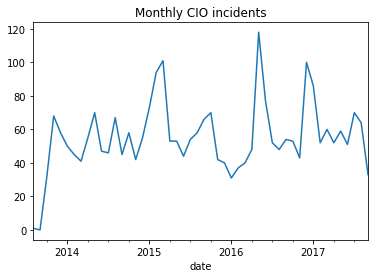

In [60]:
cio.groupby(pd.Grouper(key='date', freq='M')).size().plot()
plt.title('Monthly CIO incidents')

In [61]:
# Make year and month variables

arrest_charges['year'], arrest_charges['month'] = arrest_charges['mpd_arrest_date'].dt.year, arrest_charges['mpd_arrest_date'].dt.month
case_charges['year'], case_charges['month'] = case_charges['file_date'].dt.year, case_charges['file_date'].dt.month
crimes['year'] = crimes['offense_report_date'].dt.year
cio['year'] = cio['date'].dt.year
cio['month'] = cio['date'].dt.month

Text(0,0.5,'Number of incidents per month')

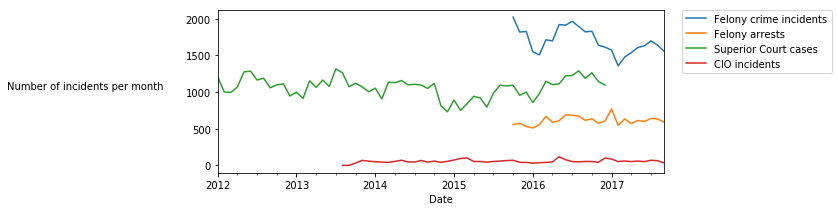

In [62]:
# Plot full source data 

fig, ax = plt.subplots(sharex=False, figsize=(8,3))

crimes.sort_values(by=['offense_report_date'], ascending=True)\
      .drop_duplicates('ccn', keep='last')\
      .groupby(pd.Grouper(key='offense_report_date', freq='M'))\
      .size()\
      .plot(ax=ax, label='Felony crime incidents')

arrest_charges.sort_values(by=['mpd_arrest_date'], ascending=True)\
              .drop_duplicates('mpd_arrest_number', keep='last')\
              .groupby(pd.Grouper(key='mpd_arrest_date', freq='M'))\
              .size()\
              .plot(ax=ax, label='Felony arrests')

case_charges.sort_values(by='file_date', ascending=True)\
            .drop_duplicates('case_no', keep='last')\
            .groupby(pd.Grouper(key='file_date', freq='M'))\
            .size()\
            .plot(ax=ax, label='Superior Court cases')

cio.groupby(pd.Grouper(key='date', freq='M'))\
   .size()\
   .plot(ax=ax, label='CIO incidents')

plt.legend(bbox_to_anchor=(1.03, 1.03))
plt.xlabel('Date')
plt.ylabel('Number of incidents per month', rotation='horizontal', labelpad=100)

In [63]:
seh_services = seh_raw[['consumer_id', 'episode_number', 'admit_date', 'discharge_date', 'category', 'source']].copy()
seh_services.sort_values(by=['consumer_id', 'episode_number', 'admit_date', 'discharge_date', 'category', 'source'], ascending=True, inplace=True)
seh_services.drop_duplicates(inplace=True)

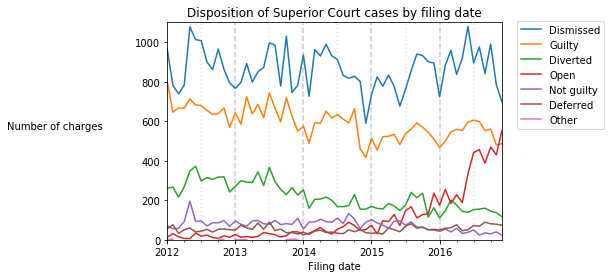

In [64]:
# Plot court outcomes over time

disposition_name_to_label = {
    'dismissed': 'Dismissed',
    'guilty': 'Guilty',
    'open': 'Open',
    'diverted': 'Diverted',
    'deferred': 'Deferred',
    'not_guilty': 'Not guilty',
    'other': 'Other'
}

hold = case_charges.disposition_category.value_counts().iloc[:8]
for idx, val in zip(hold.index, hold.values):
    tmp = case_charges[case_charges.disposition_category == idx]
    x = tmp.groupby('file_date').size().resample('M').sum()
    x.plot(label=disposition_name_to_label[idx])

ylim = plt.ylim()
ticks = plt.xticks()[0]
mid_tick = (ticks[1] - ticks[0]) / 2.0
plt.vlines(ticks[1:], 0, 1600, alpha=0.2, linestyles='dashed')
plt.vlines(ticks + mid_tick, 0, 1600, alpha=0.1, linestyles='dotted')
plt.ylim([0, 1100])
plt.xlabel('Filing date')
plt.ylabel('Number of charges', rotation='horizontal', labelpad=80)
plt.legend(bbox_to_anchor=(1.03, 1.03));
plt.title('Disposition of Superior Court cases by filing date');

#### Note on time range:
The source data we obtained covered a range of time horizons. Ultimately we decided to use and present our analysis of only data from calendar year 2016. We did this because it was the only full calendar year for which we had complete data from all partner entities. 

## Misdemeanors v. felonies

In [65]:
# How many felony and misdemeanor court cases? 

'''
Notes:

1) Classed based on whether the case title contains 'CMD', which indicates the case is a misdemeanor case
2) Misdemeanor vs felony distinction is made based on the initial charges filed
3) A felony case may contain misdemeanor charges
'''

print(case_charges['case_no'].str.contains('CMD').value_counts())

True     68820
False    46042
Name: case_no, dtype: int64


In [66]:
# Make felony/misdemeanor dummies
case_charges['is_misdemeanor'] = (case_charges['case_no'].str.contains('CMD'))
case_charges['is_felony'] = ~case_charges.is_misdemeanor

In [67]:
# Check consistency
print(case_charges.is_felony.value_counts())

False    68820
True     46042
Name: is_felony, dtype: int64


## Dummies

In [68]:
# Dummy for whether the court charge description contains the string 'assault on a pol' (i.e. is related to APO)
case_charges['is_apo'] = case_charges.charge_description.str.lower().str.startswith('assault on a pol')

# Dummy for whether the court charge description contains the string 'marij' (i.e. is related to marijuana)
case_charges['is_marijuana'] = case_charges.charge_description.str.lower().str.contains('marij')

# Dummy for whether the arrest charge description contains the string 'marij' (i.e. is related to marijuana)
arrest_charges['is_marijuana'] = arrest_charges.mpd_charge_description.str.lower().str.contains('marij')

In [69]:
# List a few examples to show what kinds of charges these captured

case_charges.loc[case_charges['is_apo'] == True][['charge_description', 'is_apo']][300:309] # (arbitrary index position)

,charge_description,is_apo
21591,Assault On A Police Officer,True
21732,Assault On A Police Officer,True
21734,Assault On A Police Officer,True
21776,Assault On A Police Officer,True
21777,Assault On A Police Officer,True
21778,Assault On A Police Officer,True
21779,Assault On A Police Officer,True
21785,Assault On A Police Officer,True
21817,Assault On A Police Officer,True


In [70]:
case_charges.loc[case_charges['is_marijuana'] == True][['charge_description', 'is_marijuana']][300:309] # (arbitrary index position)

,charge_description,is_marijuana
60882,Poss W/I to Dist Marijuana-Misd,True
60923,Distribution of Marijuana-Misd,True
60924,Poss W/I to Dist Marijuana-Misd,True
60926,Distribution of Marijuana-Misd,True
60969,Distribution of Marijuana-Misd,True
61042,Poss W/I to Dist Marijuana-Misd,True
61215,Distribution of Marijuana-Misd,True
61224,Poss W/I to Dist Marijuana-Misd,True
61510,Poss W/I to Dist Marijuana-Misd,True


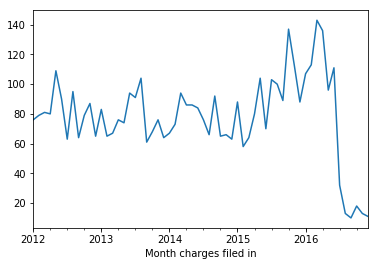

In [71]:
# Plot of APO charges in court over time
case_charges.groupby(pd.Grouper(freq='M', key='file_date')).is_apo.sum().plot(label='APO')
plt.xlabel("Month charges filed in");

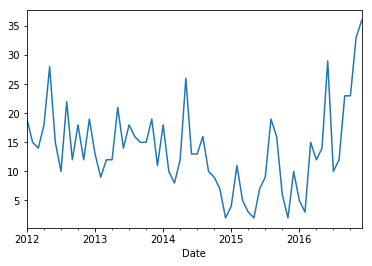

In [72]:
# Plot of marijuana charges in court over time
case_charges.groupby(pd.Grouper(freq='M', key='file_date')).is_marijuana.sum().plot()
plt.xlabel('Date');

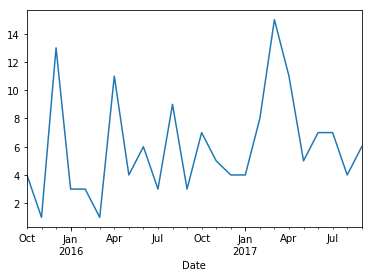

In [73]:
# Plot of felony marijuana arrests over time
arrest_charges.groupby(pd.Grouper(freq='M', key='mpd_arrest_date')).is_marijuana.sum().plot()
plt.xlabel('Date');

## Final exclusions

#### DBH data

In [74]:
# Restrict time horizon

'''
Keep only records where a person was arrested in 2016 (on felony charges) and that person had an intake date
in 2015 or 2016.
'''

arrest_year = 2016
earliest_service_year = 2015
pd.to_datetime(earliest_service_year)

mh = mh_raw[(mh_raw['year'] == arrest_year) & (mh_raw['mh_service_date'].dt.year >= earliest_service_year)]
mh.name = 'MH records (2016)'
seh = seh_raw[(seh_raw['year'] == arrest_year) & (seh_raw['admit_date'].dt.year >= earliest_service_year)]
seh.name = 'SEH records (2016)'
sud = sud_raw[(sud_raw['year'] == arrest_year) & (sud_raw['admit_date'].dt.year >= earliest_service_year)]
sud.name = 'SUD records (2016)'

In [75]:
# Date range for DBH records

print('MH data earliest service date:', mh.mh_service_date.dt.date.min())
print('MH data last service date:', mh.mh_service_date.dt.date.max())
print('SEH data earliest intake date:', seh.admit_date.dt.date.min())
print('SEH data latest intake date:', seh.admit_date.dt.date.max())
print('SUD data earliest intake date:', sud.admit_date.dt.date.min())
print('SUD data latest intake date:', sud.admit_date.dt.date.max())
print()

# Number and type of records
for df in mh, seh, sud:
    print(df.name)
    print('Length:', len(df))
    print('Unique people:', df.consumer_id.nunique())
    print('Unique arrests:', df.arrest_id.nunique())
    print()

MH data earliest service date: 2015-01-02
MH data last service date: 2017-10-24
SEH data earliest intake date: 2015-01-13
SEH data latest intake date: 2017-11-09
SUD data earliest intake date: 2015-01-02
SUD data latest intake date: 2017-11-20

MH records (2016)
Length: 77262
Unique people: 1382
Unique arrests: 1654

SEH records (2016)
Length: 304
Unique people: 165
Unique arrests: 220

SUD records (2016)
Length: 1449
Unique people: 560
Unique arrests: 677



#### Superior Court cases

In [76]:
# Drop court case rows that are missing PDIDs

print('Case charges:')
print('Length:', len(case_charges))
print('Count null PDID (before):', case_charges.pdid.isnull().sum())

case_charges.dropna(subset=['pdid'], inplace=True)

print('Length:', len(case_charges))
print('Count null PDID (after):', case_charges.pdid.isnull().sum())

Case charges:
Length: 114862
Count null PDID (before): 623
Length: 114239
Count null PDID (after): 0


#### Felony arrests

In [77]:
# Drop missing PDIDs from arrests

print('Arrest charges:')
print('Length:', len(arrest_charges))
print('Count null PDID (before):', arrest_charges.pdid.isnull().sum())
arrest_charges.dropna(subset=['pdid'], inplace=True)
print('Length:', len(arrest_charges))
print('Count null PDID (after):', arrest_charges.pdid.isnull().sum())

Arrest charges:
Length: 18671
Count null PDID (before): 105
Length: 18566
Count null PDID (after): 0


In [78]:
# One individual had 25 arrests recorded on one day 2016. Not sure how to interpret that so deleting those records

odd_pdid = ###### # Actual PDID redacted

'''
Drop the one person who had 25 arrests on one day. Note that there are other valid arrests associated with this PDID, so I drop
the 25 invalid arrests that happened on one day in 2016 but allow the other arrests to remain.
'''

arrest_charges.drop(arrest_charges[\
                                   (arrest_charges['pdid'] == odd_pdid) & \
                                   (arrest_charges['mpd_arrest_date'].dt.year == 2016)\
                                  ].index, inplace=True)

In [79]:
len(arrest_charges)

18543

In [80]:
# Name dataframes (the names were over-written during merges)

arrest_charges.name = 'MPD felony arrest charge records'
case_charges.name = 'Superior Court case records'
crimes.name = 'MPD felony crime incident records'

In [81]:
for df in [arrest_charges, case_charges, crimes]:
    print(df.name)
    print(df.year.value_counts())
    print()

MPD felony arrest charge records
2016    9274
2017    7272
2015    1997
Name: year, dtype: int64

Superior Court case records
2016    24170
2012    23937
2013    23371
2014    21540
2015    21221
Name: year, dtype: int64

MPD felony crime incident records
2016    49881
2017    32835
2015    13664
Name: year, dtype: int64



In [82]:
# Keep only records from 2016

arrest_charges = arrest_charges[arrest_charges['year'] == 2016].copy()
print('Arrest charges length: ', len(arrest_charges))
case_charges = case_charges[case_charges['year'] == 2016].copy()
print('Case charges length: ', len(case_charges))
crimes = crimes[crimes['year'] == 2016].copy()
print('Crimes length: ', len(crimes))
cio = cio[cio['year'] == 2016].copy()
print('CIO length: ', len(cio))

Arrest charges length:  9274
Case charges length:  24170
Crimes length:  49881
CIO length:  701


In [83]:
# Number of crime incidents in 2016 crime incident data
crimes.ccn.nunique()

21043

In [84]:
# Number of arrests in 2016 felony arrest data
arrest_charges.mpd_arrest_number.nunique()

7339

### Anonymize dataframes

In [85]:
"""
Tools for anonymizing pandas DataFrames.
@author Kevin H. Wilson <kevin.wilson@dc.gov>
"""

def anonymize_str_columns(df, cols, current_map=None, inplace=False):
    """
    Given a collection of columns `cols` in a DataFrame `df`,
    assume they all are strings. Replace all the values, including
    those common across columns, with a unique, random string.
    If `current_map` is not None, then it will be used first to determine
    the values of the columns.

    For example, if `df` looks like::
        A | B | C
       -----------
        a | b | x
        a | a | y
        b | c | z

    and `cols == ['A', 'B']`, then the output might look like::

        A | B | C
        -----------
        1 | 2 | x
        1 | 1 | y
        2 | 3 | z

    Args:
        df (pd.DataFrame): The DataFrame whose columns to anonymize
        cols (list[str]): The list of column names to anonymize
        current_map (dict[str, str]|None): The map of keys to values to append to
        inplace (bool): Should the anonymization be done in place?
    Returns:
        pd.DataFrame: The anonymized DataFrame
        dict[str, str]: The map of anonymized values
    """
    if type(cols) not in (list, tuple):
        cols = [cols]

    if not current_map:
        current_map = {}

    old_keys = set(current_map.keys())
    old_vals = set(current_map.values())

    new_keys = set()
    for col in cols:
        new_keys.update(df[col])
        new_keys -= old_keys

    # Keep the probability of collisions relatively low, but
    # keep the size at least a standard 16 bytes
    nbytes = max(4 + int(math.log(len(new_keys) + len(old_keys)) / math.log(8)), 16)
    for new_key in new_keys:
        new_val = secrets.token_bytes(nbytes=nbytes)
        while new_val in old_vals:
            new_val = secrets.token_bytes(nbytes=nbytes)
        current_map[new_key] = str(int(binascii.hexlify(new_val), 16)) # Converts byte string into hex, reading that as an integer

    if not inplace:
        df = df.copy()

    for col in cols:
        df.loc[:, col] = df[col].map(current_map)

    return df, current_map

In [86]:
map_of_vals = {}

arrest_charges_anon, map_of_vals = anonymize_str_columns(arrest_charges, ['mpd_arrest_number', 'pdid', 'ccn'], map_of_vals)
crimes_anon, map_of_vals = anonymize_str_columns(crimes, ['ccn'], map_of_vals)

In [87]:
# Delete explicitly identifiable columns

ID_COLUMNS = [
    
    'home_address', 
    'home_zip', 
    'dob', 
    'first_name', 
    'last_name'
    
]

arrest_charges_anon = arrest_charges_anon.drop(ID_COLUMNS, axis=1)

# Delete columns that were incorrectly pulled in the source data

arrest_charges_anon = arrest_charges_anon.drop(['mpd_charge_disposition', 'mpd_disposition_date'], axis=1)

In [88]:
# Recode age < 18 to '-1' for privacy
crimes_anon['age'] = pd.to_numeric(crimes_anon['age'], errors='coerce')
crimes_anon.loc[crimes_anon['age'] < 18, 'age'] = -1

In [90]:
list(arrest_charges_anon)

['mpd_arrest_number',
 'mpd_arrest_date',
 'person_type',
 'top_charge',
 'mpd_charge_category',
 'mpd_charge_description',
 'charge_code',
 'age',
 'arrest_count',
 'race',
 'ethnicity',
 'sex',
 'home_psa',
 'arrest_district',
 'arrest_psa',
 'home_city',
 'home_state',
 'pdid',
 'ccn',
 'latitude',
 'longitude',
 'dmpsj_category',
 'year',
 'month',
 'is_marijuana']

In [91]:
list(crimes_anon)

['ccn',
 'person_type',
 'offense_report_date',
 'profile_type',
 'offense_category',
 'offense_description',
 'charge_code',
 'age',
 'race',
 'ethnicity',
 'sex',
 'home_psa',
 'offense_location_district',
 'offense_location_psa',
 'latitude',
 'longitude',
 'dmpsj_category',
 'year']

In [92]:
list(case_charges)

['case_id',
 'case_type',
 'case_no',
 'file_date',
 'pdid',
 'last_name',
 'first_name',
 'dob',
 'sex',
 'race',
 'charge_number',
 'offense_date',
 'court_arrest_code',
 'arrest_charge_description',
 'prosecution_attempt_sequence',
 'prosecution_attempt_code',
 'prosecution_charge_code',
 'prosecution_enhance_sequence',
 'prosecution_enhance_code',
 'prosecution_attempt_description',
 'prosecution_charge_description',
 'prosecution_enhance_description',
 'indict_attempt_sequence',
 'indict_attempt_code',
 'indict_charge_code',
 'indict_enhance_sequence',
 'indict_enhance_code',
 'indict_attempt_description',
 'indict_charge_description',
 'indict_enhance_description',
 'court_attempt_sequence',
 'court_attempt_code',
 'court_charge_code',
 'court_enhance_sequence',
 'court_enhance_code',
 'court_attempt_description',
 'court_charge_description',
 'court_enhance_description',
 'charge_disposition_date',
 'charge_disposition_code',
 'charge_disposition',
 'charge_code',
 'charge_descr

## Write clean CSVs

In [93]:
# Write these cleaned files

# Public data
arrest_charges_anon.to_csv(os.path.join(PUBLIC_OUTPUT_DATA, 'arrest_charges_anon.csv'), index=False)
crimes_anon.to_csv(os.path.join(PUBLIC_OUTPUT_DATA, 'crimes_anon.csv'), index=False)

# Not public data
case_charges.to_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'case_charges.csv'), index=False)
cio.to_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'cio_incidents.csv'), index=False)
mh.to_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'mental_health_services.csv'), index=False)
seh.to_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'saint_elizabeths_records.csv'), index=False)
sud.to_csv(os.path.join(NOT_PUBLIC_OUTPUT_DATA, 'substance_use_disorder_services.csv'), index=False)